# 1基于多臂老虎机环境的RL

## 1.1估计期望奖励

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### 1.1.1定义老虎机环境Env

In [3]:
class Bandit:
    def __init__(self, K):
        self.probs = np.random.uniform(size=K) # 随机生成K个0～1的数,作为拉动每根拉杆的获奖概率
        self.best_idx = np.argmax(self.probs) # 获奖概率最大的拉杆
        self.best_prob = self.probs[self.best_idx] # 获奖概率最大的拉杆所对应的获奖概率
        self.K = K
    
    def step(self, k): #k相当于一个action，即选择k号老虎机
        if np.random.rand() < self.probs[k]: #该if结构描述了k号老虎机的获奖概率分布
            return 1
        else:
            return 0    

多臂老虎机环境并不是一个动态环境，action不会改变环境的state。因此是一个无状态强化学习问题，从上述代码中可以看到step并没有返回state值。

In [4]:
#测试环境
np.random.seed(1)
K = 10
bandit_10_arm = Bandit(K)
print(f'生成{K}臂老虎机')
print(f'获奖概率最大的拉杆为{bandit_10_arm.best_idx}号，概率为{bandit_10_arm.best_prob}')

生成10臂老虎机
获奖概率最大的拉杆为1号，概率为0.7203244934421581


### 1.1.2定义解决算法Policy

在介绍算法之前，我们要介绍一种新的期望求解方法来代替蒙特卡洛求解方法————增量式期望更新方法（incremental mean）  
其推导过程如下：  
$$
\begin{align}
  & {{Q}_{k}}=\frac{1}{k}\sum\limits_{i=1}^{k}{{{r}_{i}}} \\ 
 & =\frac{1}{k}({{r}_{k}}+\sum\limits_{i=1}^{k-1}{{{r}_{i}}}) \\ 
 & =\frac{1}{k}({{r}_{k}}+(k-1){{Q}_{k-1}}) \\ 
 & =\frac{1}{k}({{r}_{k}}+k{{Q}_{k-1}}-{{Q}_{k-1}}) \\ 
 & ={{Q}_{k-1}}+\frac{1}{k}[{{r}_{k}}-{{Q}_{k-1}}] \\ 
\end{align}
$$

In [5]:
#构造算法基类
class Solver:
    def __init__(self, bandit):
        self.bandit = bandit
        self.counts = np.zeros(self.bandit.K) #每根拉杆的尝试次数
        self.regret = 0 #当前时间步下的累积懊悔
        self.actions = [] #记录每个时间步的动作
        self.regrets = [] #记录每个时间步下的累积懊悔
    
    def update_regret(self, k): #计算累积懊悔
        self.regret += self.bandit.best_prob - self.bandit.probs[k]
        self.regrets.append(self.regret)
        
    def run_one_step(self):
        #依据当前算法选择action
        raise NotImplementedError
        
    def run(self, num_steps): 
        for _ in range(num_steps):
            k = self.run_one_step()
            self.counts[k] += 1
            self.actions.append(k)
            self.update_regret(k)     

- epsilon-贪心算法

In [35]:
class EpsilonGreedy(Solver):
    def __init__(self, bandit, epsilon, init_prob=1.0):
        super(EpsilonGreedy, self).__init__(bandit)
        self.epsilon = epsilon
        #初始化奖励估值
        self.estimates = np.array([init_prob] * self.bandit.K) #得到一个1*K的Suzuki
        
    def run_one_step(self): #基于贪心算法重写step函数
        """采用贪心算法策略啊选取动作"""
        if np.random.random() < self.epsilon:
            k = np.random.randint(0, self.bandit.K) #随机选取拉杆
        else:
            k = np.argmax(self.estimates) #选取期望最高的拉杆
        """根据动作获取奖励"""
        r = self.bandit.step(k) #本次动作的奖励
        '''更新动作期望估计'''
        self.estimates[k] += 1.0 / (self.counts[k] + 1) * (r - self.estimates[k])
        return k

In [6]:
def plot_results(solvers, solver_names):
    """生成累积懊悔随时间变化的图像。输入solvers是一个列表,列表中的每个元素是一种特定的策略。
    而solver_names也是一个列表,存储每个策略的名称"""
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list, solver.regrets, label=solver_names[idx])
    plt.xlabel('Time steps')
    plt.ylabel('Cumulative regrets')
    plt.title('%d-armed bandit' % solvers[0].bandit.K)
    plt.legend()
    plt.show()

epsilon-贪婪算法的累积懊悔为： 1013.3387483004161


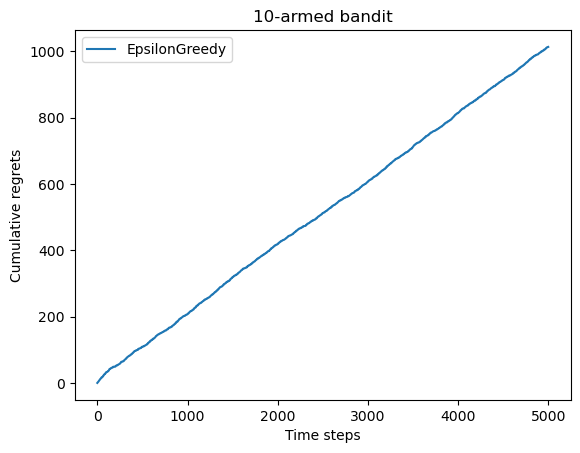

In [37]:
np.random.seed(1)
epsilon_greedy_solver = EpsilonGreedy(bandit_10_arm, epsilon=0.5) #输入环境，以及贪心程度
epsilon_greedy_solver.run(5000)
print('epsilon-贪婪算法的累积懊悔为：', epsilon_greedy_solver.regret)
plot_results([epsilon_greedy_solver], ["EpsilonGreedy"])

- 随时间衰减的epsilon贪心算法

也就是说在一开始epsilon较大模型比较倾向于探索，不拘泥于目前最优解；随着探索的进行环境已经被摸索的差不多了，epsilon也逐步缩小开始倾向于决策寻找最优解。这里我们令$epsilon=\frac{1}{t}$

In [9]:
class DecayEpsilonGreedy(Solver):
    def __init__(self, bandit, init_prob=1.0):
        super(DecayEpsilonGreedy, self).__init__(bandit)
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.total_counts = 0
        
    def run_one_step(self):
        self.total_counts += 1
        if np.random.random() < 1.0 / self.total_counts: #epsilon随时间递减
            k = np.random.randint(0, self.bandit.K)  # 随机选择一根拉杆
        else:
            k = np.argmax(self.estimates)  # 选择期望奖励估值最大的拉杆  
        r = self.bandit.step(k)
        self.estimates[k] += 1.0 / (self.counts[k] + 1) * (r - self.estimates[k])
        return k

衰减epsilon-贪婪算法的累积懊悔为： 10.114334931260183


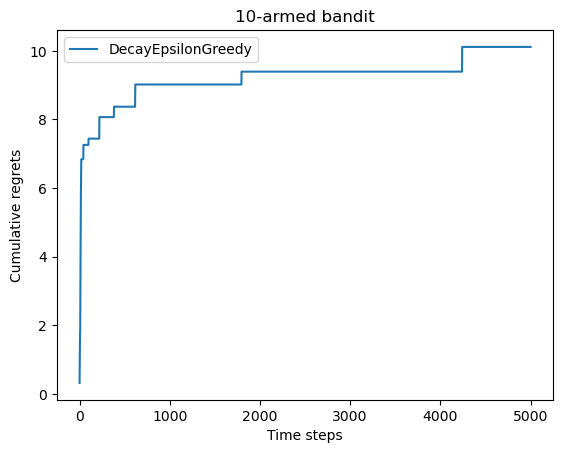

In [10]:
np.random.seed(1)
epsilon_greedy_solver = DecayEpsilonGreedy(bandit_10_arm) #输入环境，以及贪心程度
epsilon_greedy_solver.run(5000)
print('衰减epsilon-贪婪算法的累积懊悔为：', epsilon_greedy_solver.regret)
plot_results([epsilon_greedy_solver], ["DecayEpsilonGreedy"])

- 上置信界算法(UCB)

这是一种基于不确定度的算法，其基本思想是一直选取上置信界最大者：  
一开始由于不确定度很大，此标准选取的可能不是最有解，但是没关系，这有利于模型进行环境探索；随着试验次数增加，不确定度降低，上置信界越来越区趋于真实值，这时此标准将有利于模型进行决策。  
综上，该算法的关键就是要合理的描述模型的不确定度，根据霍夫丁不等式

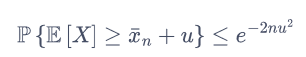  
可以求解出各动作的不确定度：  
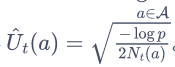

In [13]:
class UCB(Solver):
    def __init__(self, bandit, coef, init_prob=1.0):
        super(UCB, self).__init__(bandit)
        self.total_count = 0
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.coef =coef
        
    def run_one_step(self):
        self.total_count += 1
        #计算动作空间的UCB，这里p=1/t 为避免分母count为0 进行加1
        ucb = self.estimates + self.coef * np.sqrt(np.log(self.total_count) / (2 * (self.counts + 1)))
        k = np.argmax(ucb)
        r = self.bandit.step(k)
        self.estimates[k] += 1.0 / (self.counts[k] + 1) * (r - self.estimates[k])
        return k

上置信界算法的累积懊悔为： 70.45281214197854


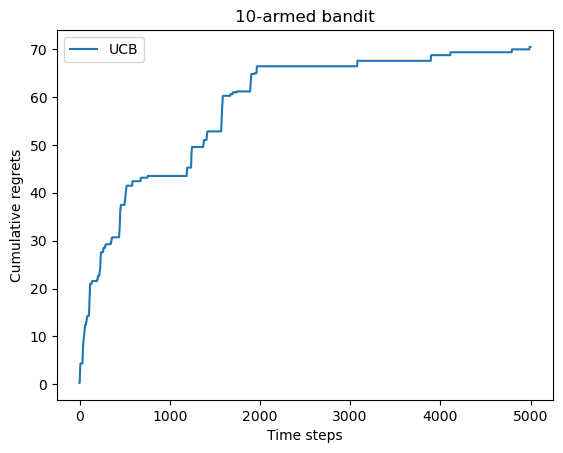

In [14]:
np.random.seed(1)
coef = 1  # 控制不确定性比重的系数
UCB_solver = UCB(bandit_10_arm, coef)
UCB_solver.run(5000)
print('上置信界算法的累积懊悔为：', UCB_solver.regret)
plot_results([UCB_solver], ["UCB"])

- 汤普森采样算法

基于bate分布进行采样

In [18]:
class ThompsonSampling(Solver):
    """ 汤普森采样算法,继承Solver类 """
    def __init__(self, bandit):
        super(ThompsonSampling, self).__init__(bandit)
        #对每个拉杆的奖励概率分布进行初始化（1，1）bate分布
        self._a = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为1的次数
        self._b = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为0的次数

    def run_one_step(self):
        #注意这里的sample是对每一个arm进行一次抽样，每一次抽取样本数等于num_arms,不是只抽一个.
        samples = np.random.beta(self._a, self._b)  # 按照Beta分布采样一组奖励样本
        k = np.argmax(samples)  # 选出采样奖励最大的拉杆
        r = self.bandit.step(k)

        self._a[k] += r  # 更新Beta分布的第一个参数
        self._b[k] += (1 - r)  # 更新Beta分布的第二个参数
        return k

汤普森采样算法的累积懊悔为： 57.19161964443925


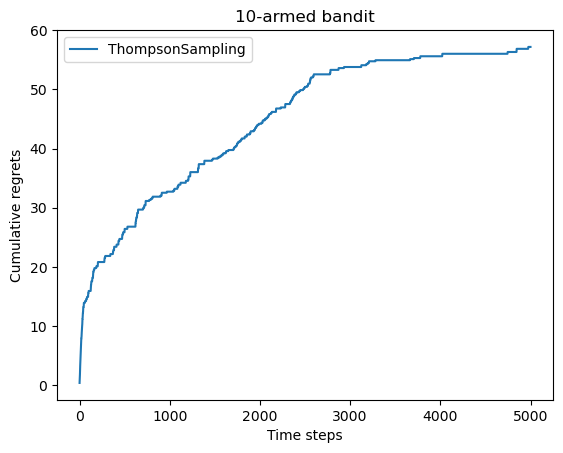

In [19]:
np.random.seed(1)
thompson_sampling_solver = ThompsonSampling(bandit_10_arm)
thompson_sampling_solver.run(5000)
print('汤普森采样算法的累积懊悔为：', thompson_sampling_solver.regret)
plot_results([thompson_sampling_solver], ["ThompsonSampling"])

本章，通过老虎机环境我们对exploration-exploitation dilemma 有了一个比较好的认识，对于一个策略（ploicy）既要可以充分的探索环境，也可以较好的找到最优策略